In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)


In [2]:
# reading the dataset
homeraw = pd.read_csv("train.csv")

# Data Cleaning and Preparation

In [3]:
#Converting to Lowercase only for Str type
homeraw = homeraw.applymap(lambda x: x.lower() if type(x) == str else x)

#Checking for Null values
homeraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
#Dropping Columns which either have high percentage of missing values or values which might not be of used for this analysis
homeraw = homeraw.drop(['Id', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)

In [5]:
#imputing missing categorical values wit Mode
homeraw['MasVnrType'] = homeraw['MasVnrType'].fillna(homeraw['MasVnrType'].mode()[0])
homeraw['BsmtQual'] = homeraw['BsmtQual'].fillna(homeraw['BsmtQual'].mode()[0])
homeraw['BsmtCond'] = homeraw['BsmtCond'].fillna(homeraw['BsmtCond'].mode()[0])
homeraw['BsmtExposure'] = homeraw['BsmtExposure'].fillna(homeraw['BsmtExposure'].mode()[0])
homeraw['BsmtFinType1'] = homeraw['BsmtFinType1'].fillna(homeraw['BsmtFinType1'].mode()[0])
homeraw['BsmtFinType2'] = homeraw['BsmtFinType2'].fillna(homeraw['BsmtFinType2'].mode()[0])
homeraw['Electrical'] = homeraw['Electrical'].fillna(homeraw['Electrical'].mode()[0])
homeraw['GarageType'] = homeraw['GarageType'].fillna(homeraw['GarageType'].mode()[0])
homeraw['GarageFinish'] = homeraw['GarageFinish'].fillna(homeraw['GarageFinish'].mode()[0])
homeraw['GarageQual'] = homeraw['GarageQual'].fillna(homeraw['GarageQual'].mode()[0])
homeraw['GarageCond'] = homeraw['GarageCond'].fillna(homeraw['GarageCond'].mode()[0])

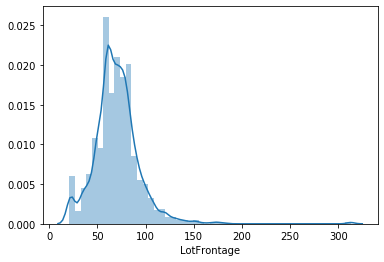

In [6]:
#Seeing distribution plot of LotFrontage which has missing values
sns.distplot(homeraw['LotFrontage'])
plt.show()

In [7]:
#Seeing Summary of statistics of LotFrontage which has missing values
homeraw['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [8]:
#Since Median and Mean are not much different for LotFrontage we can use either to impute missing values
homeraw['LotFrontage'] = homeraw['LotFrontage'].fillna(homeraw['LotFrontage'].median())

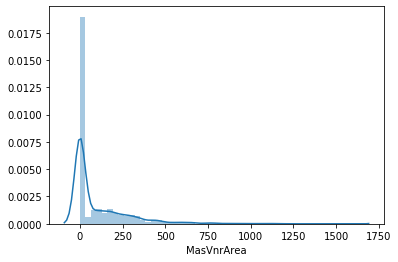

In [9]:
#Seeing distribution plot of MasVnrArea which has missing values
sns.distplot(homeraw['MasVnrArea'])
plt.show()

In [10]:
#Seeing Summary of statistics of MasVnrArea which has missing values
homeraw['MasVnrArea'].describe()

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

In [11]:
#Since MasVnrArea area has very skewed values with Median at zero, we will drop that column from dataset
homeraw = homeraw.drop(['MasVnrArea'], axis=1)

In [12]:
#Imputing Missing values for GarageYrBlt with Values from YearBuilt which woud be more appropriate
homeraw['GarageYrBlt'] = homeraw['GarageYrBlt'].fillna(homeraw['YearBuilt'])

In [13]:
#Converting Year remodelled into Age of the House and Year Garage built into age of Garage

import datetime
now = datetime.datetime.now()
homeraw['age'] = now.year - homeraw['YearRemodAdd']
homeraw['garageage'] = now.year - homeraw['GarageYrBlt']

#Dropping Year Buit, remodelled, Garage built year
homeraw = homeraw.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1)


In [14]:
# Identifying columns which has 85% values which is same

# Method to get the column names that have count of one value more than 85%

def samevaluecolumns():
    column = []
    categorical_columns = homeraw.select_dtypes(include=['object'])
    for col in (categorical_columns):
        if(homeraw[col].value_counts().max() >= 1241):
            column.append(col)
    return column

columnsToBeRemoved = samevaluecolumns()

# Remove the columns with skewed data

homeraw.drop(columnsToBeRemoved, axis = 1, inplace = True)



In [15]:
#Checking the homeraw dataframe
homeraw.head()

MSSubClass MSZoning  LotFrontage  LotArea LotShape LotConfig Neighborhood  \
0          60       rl         65.0     8450      reg    inside      collgcr   
1          20       rl         80.0     9600      reg       fr2      veenker   
2          60       rl         68.0    11250      ir1    inside      collgcr   
3          70       rl         60.0     9550      ir1    corner      crawfor   
4          60       rl         84.0    14260      ir1       fr2      noridge   

  BldgType HouseStyle  OverallQual  OverallCond RoofStyle Exterior1st  \
0     1fam     2story            7            5     gable     vinylsd   
1     1fam     1story            6            8     gable     metalsd   
2     1fam     2story            7            5     gable     vinylsd   
3     1fam     2story            7            5     gable     wd sdng   
4     1fam     2story            8            5     gable     vinylsd   

  Exterior2nd MasVnrType ExterQual Foundation BsmtQual BsmtExposure  \
0     vinylsd    brkface        gd      pconc       gd           no   
1     metalsd       none        ta     cblock       gd           gd   
2     vinylsd    brkface        gd      pconc       gd           mn   
3     wd shng       none        ta     brktil       ta           no   
4     vinylsd    brkface        gd      pconc       gd           av   

  BsmtFinType1  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF HeatingQC  \
0          glq         706           0        150          856        ex   
1          alq         978           0        284         1262        ex   
2          glq         486           0        434          920        ex   
3          alq         216           0        540          756        gd   
4          glq         655           0        490         1145        ex   

   1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
0       856       854             0       1710             1             0   
1      1262         0             0       1262             0             1   
2       920       866             0       1786             1             0   
3       961       756             0       1717             1             0   
4      1145      1053             0       2198             1             0   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd  \
0         2         1             3             1          gd             8   
1         2         0             3             1          ta             6   
2         2         1             3             1          gd             6   
3         1         0             3             1          gd             7   
4         2         1             4             1          gd             9   

   Fireplaces GarageType GarageFinish  GarageCars  GarageArea  WoodDeckSF  \
0           0     attchd          rfn           2         548           0   
1           1     attchd          rfn           2         460         298   
2           1     attchd          rfn           2         608           0   
3           1     detchd          unf           3         642           0   
4           1     attchd          rfn           3         836         192   

   OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  \
0           61              0          0            0         0        0   
1            0              0          0            0         0        0   
2           42              0          0            0         0        0   
3           35            272          0            0         0        0   
4           84              0          0            0         0        0   

   MoSold  YrSold SaleCondition  SalePrice  age  garageage  
0       2    2008        normal     208500   17       17.0  
1       5    2007        normal     181500   44       44.0  
2       9    2008        normal     223500   18       19.0  
3       2    2006       abnorml     140000   50       22.0  
4      12    2008        norma

In [16]:
#Checking for Null values
homeraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   LotShape       1460 non-null   object 
 5   LotConfig      1460 non-null   object 
 6   Neighborhood   1460 non-null   object 
 7   BldgType       1460 non-null   object 
 8   HouseStyle     1460 non-null   object 
 9   OverallQual    1460 non-null   int64  
 10  OverallCond    1460 non-null   int64  
 11  RoofStyle      1460 non-null   object 
 12  Exterior1st    1460 non-null   object 
 13  Exterior2nd    1460 non-null   object 
 14  MasVnrType     1460 non-null   object 
 15  ExterQual      1460 non-null   object 
 16  Foundation     1460 non-null   object 
 17  BsmtQual       1460 non-null   object 
 18  BsmtExpo

In [17]:
#Creating Numerical values in separate dataframe
homeraw_numeric = homeraw.select_dtypes(include=['float64', 'int64'])

<Figure size 1440x720 with 0 Axes>

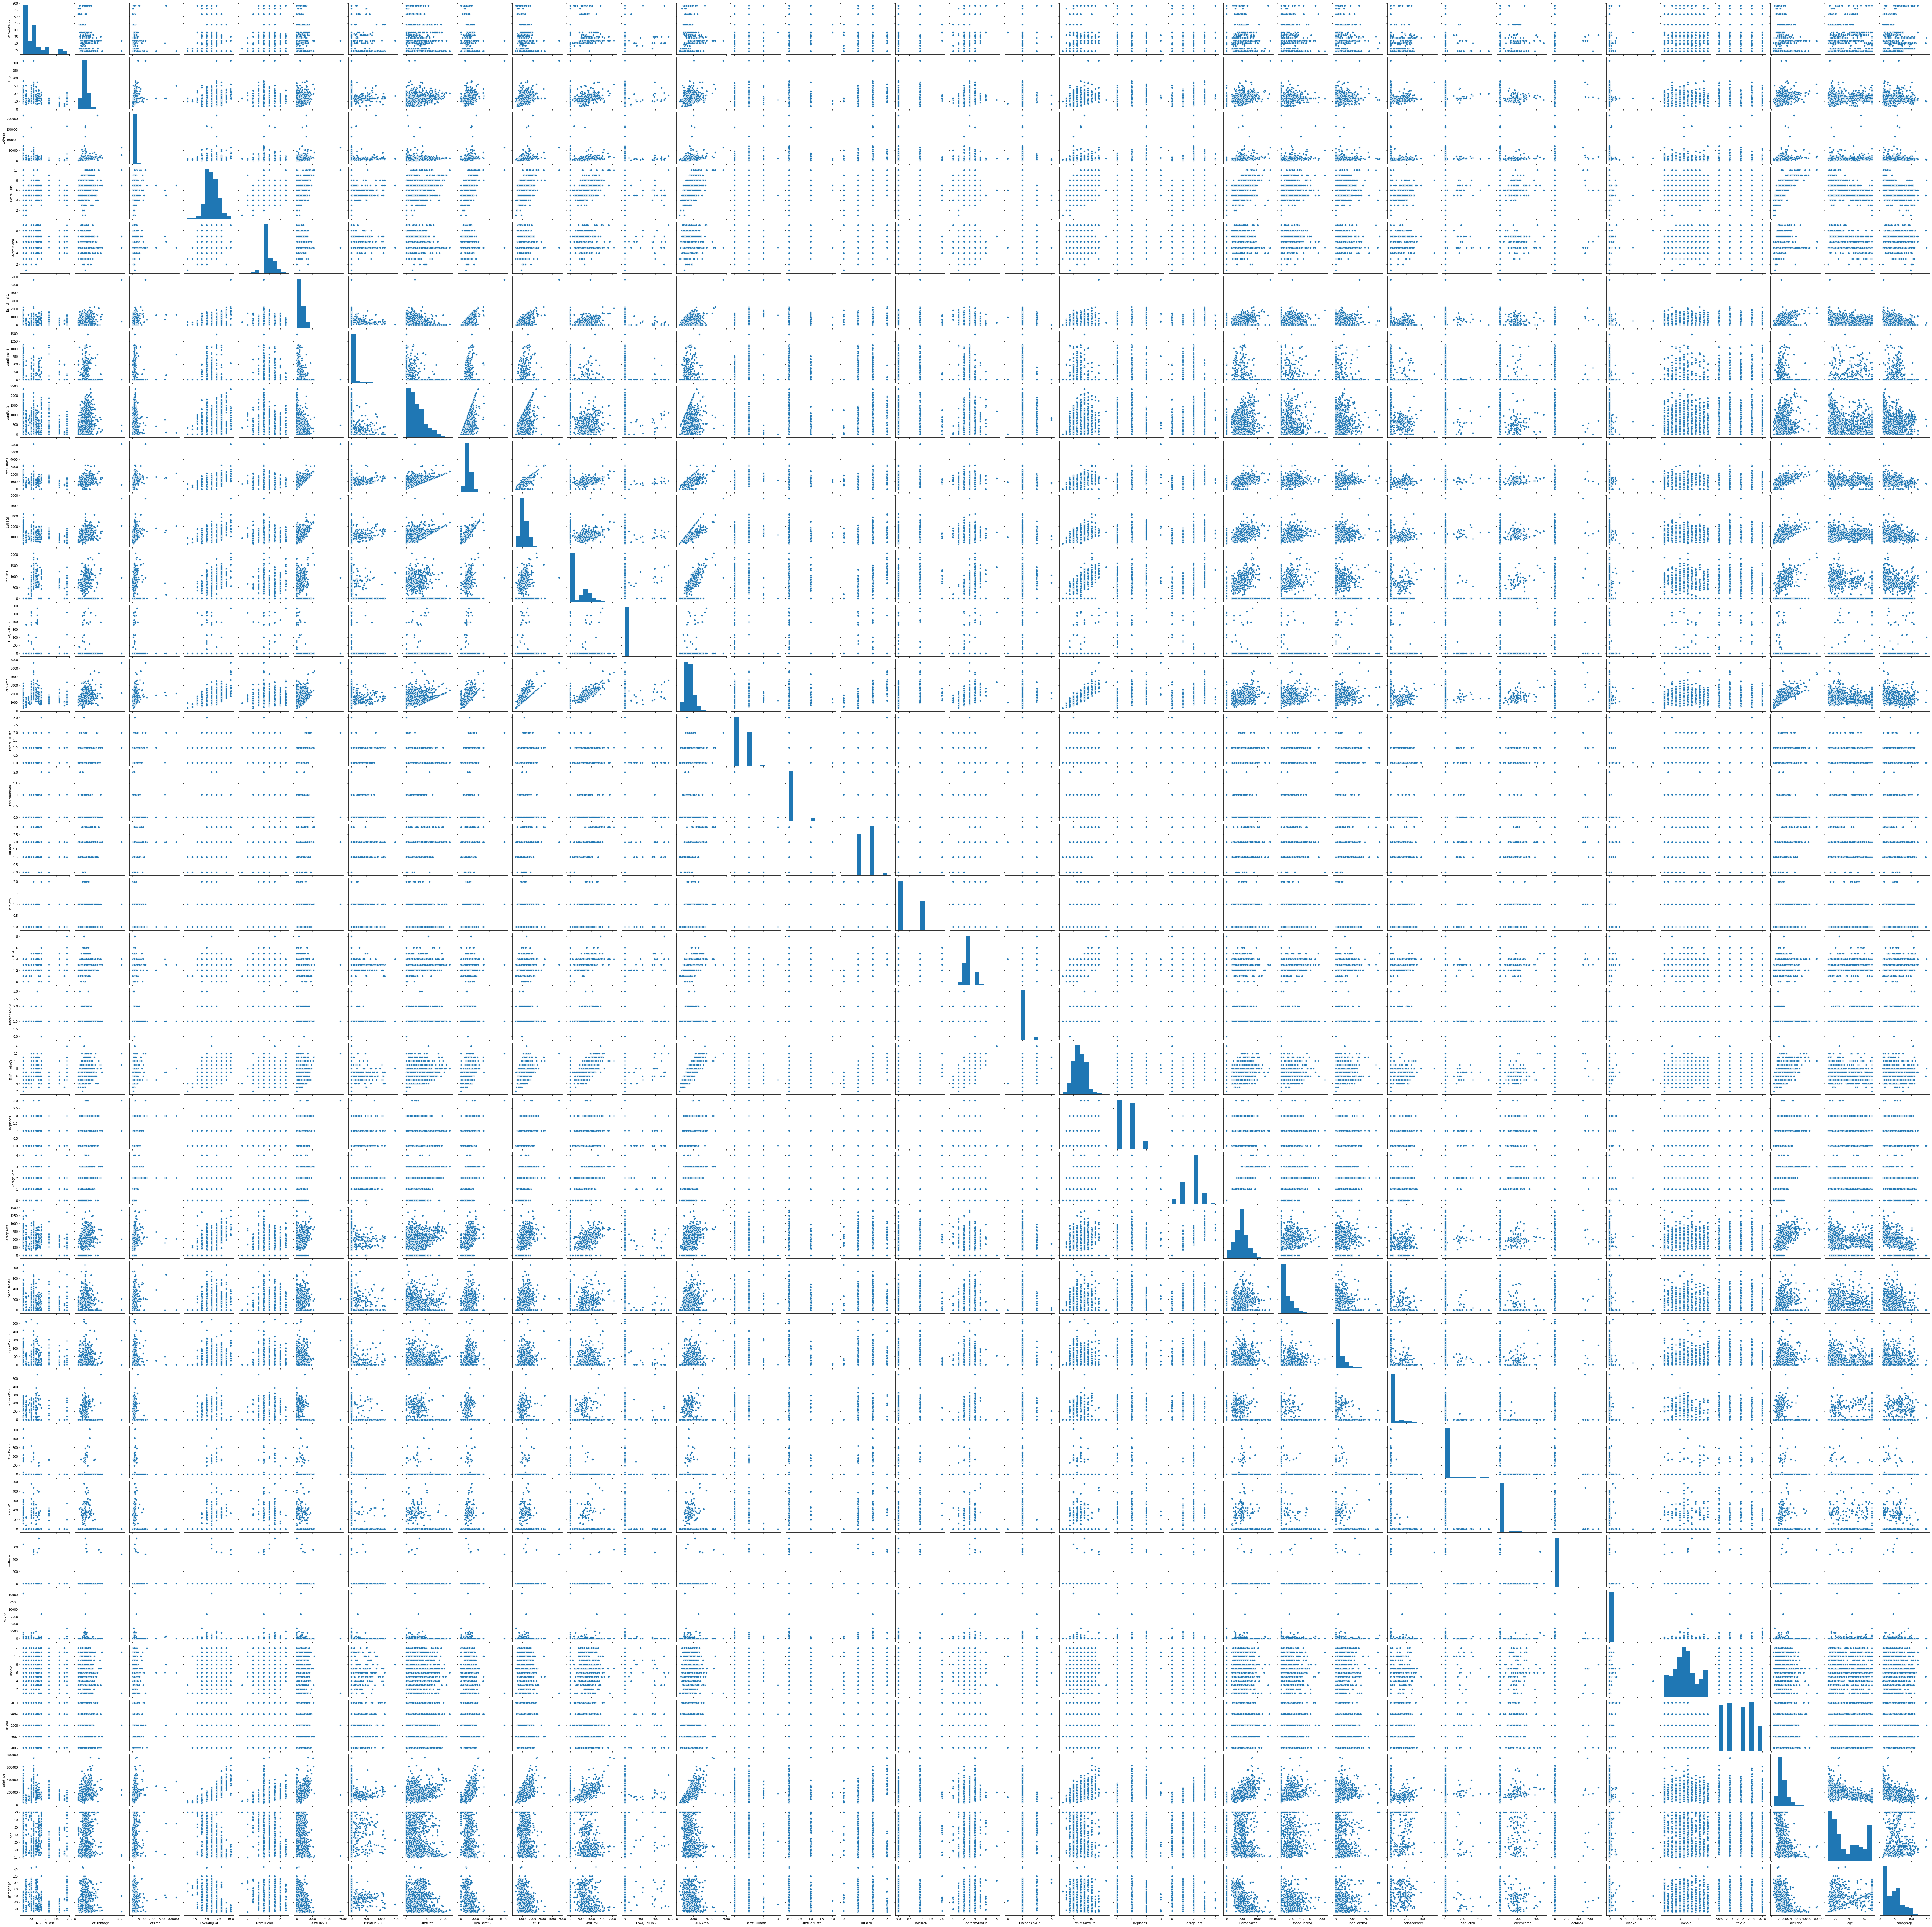

In [18]:
# paiwise scatter plot of Numerical values

plt.figure(figsize=(20, 10))
sns.pairplot(homeraw_numeric)
plt.show()

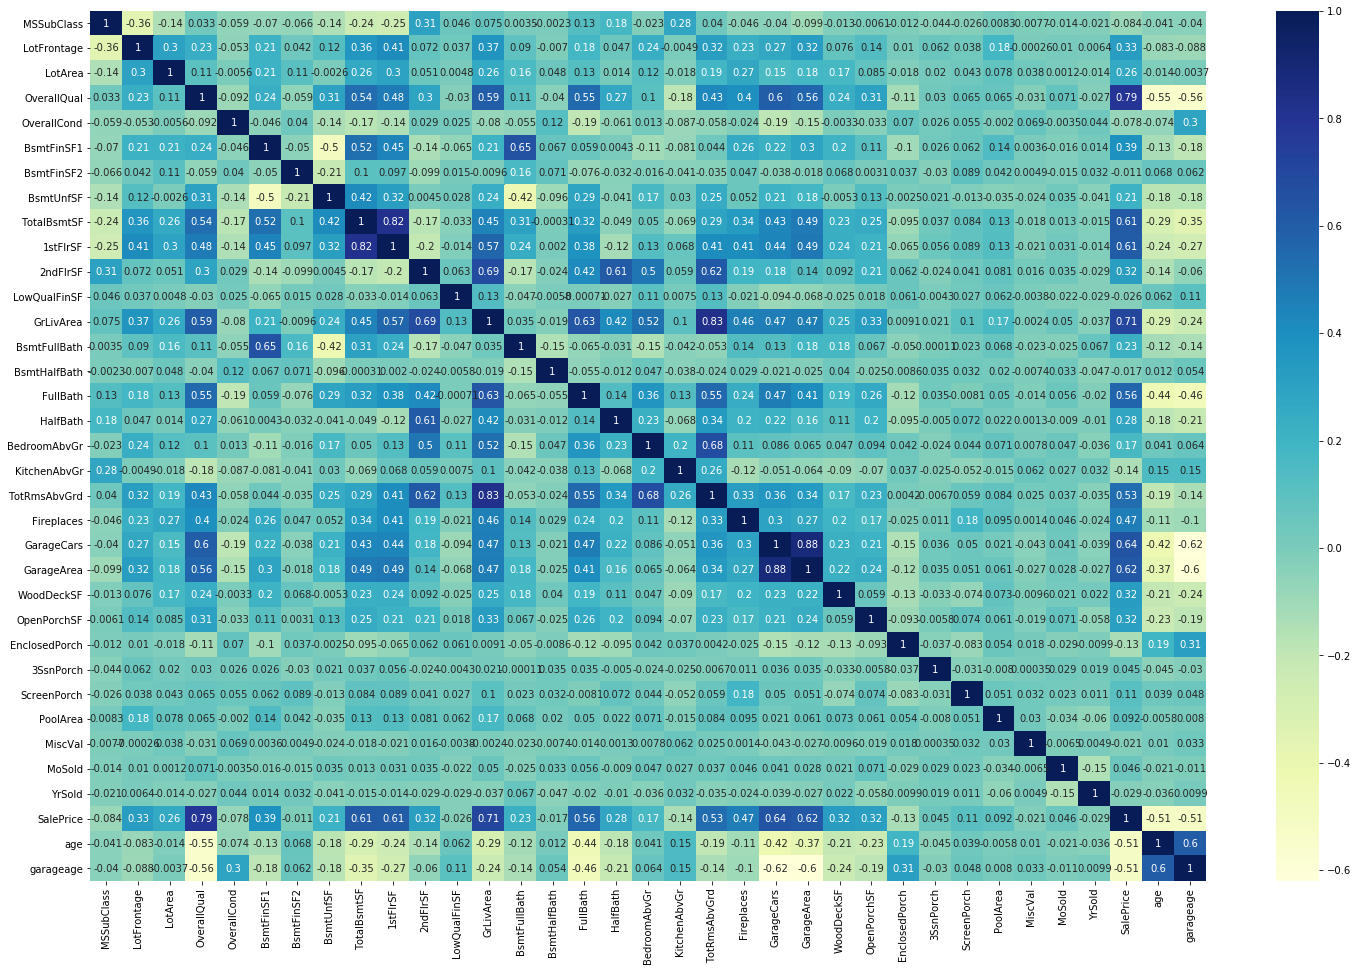

In [19]:
#Created Correlation Matrix for Numerical values
cor = homeraw_numeric.corr()
# heatmap
plt.figure(figsize=(25,16))
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

In [20]:
#Seeing the statistical summary of Numerical values
homeraw_numeric.describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    69.863699   10516.828082     6.099315     5.575342   
std      42.300571    22.027677    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    60.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    79.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

        BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean    443.639726    46.549315   567.240411  1057.429452  1162.626712   
std     456.098091   161.319273   441.866955   438.705324   386.587738   
min       0.000000     0.000000     0.000000     0.000000   334.000000   
25%       0.000000     0.000000   223.000000   795.750000   882.000000   
50%     383.500000     0.000000   477.500000   991.500000  1087.000000   
75%     712.250000     0.000000   808.000000  1298.250000  1391.250000   
max    5644.000000  1474.000000  2336.000000  6110.000000  4692.000000   

          2ndFlrSF  LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath  \
count  1460.000000   1460.000000  1460.000000   1460.000000   1460.000000   
mean    346.992466      5.844521  1515.463699      0.425342      0.057534   
std     436.528436     48.623081   525.480383      0.518911      0.238753   
min       0.000000      0.000000   334.000000      0.000000      0.000000   
25%       0.000000      0.000000  1129.500000      0.000000      0.000000   
50%       0.000000      0.000000  1464.000000      0.000000      0.000000   
75%     728.000000      0.000000  1776.750000      1.000000      0.000000   
max    2065.000000    572.000000  5642.000000      3.000000      2.000000   

          FullBath     HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  \
count  1460.000000  1460.000000   1460.000000   1460.000000   1460.000000   
mean      1.565068     0.382877      2.866438      1.046575      6.517808   
std       0.550916     0.502885      0.815778      0.220338      1.625393   
min       0.000000     0.000000      0.000000      0.000000      2.000000   
25%       1.000000     0.000000      2.000000      1.000000      5.000000   
50%       2.000000     0.000000      3.000000      1.000000      6.000000   
75%       2.000000     1.000000      3.000000      1.000000      7.000000   
max       3.000000     2.000000      8.000000      3.000000     14.000000   

        Fireplaces   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean      0.613014     1.767123   472.980137    94.244521    46.660274   
std       0.644666     0.747315   213.804841   125.338794    66.256028   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     1.000000   334.500000     0.000000     0.000000   
50%       1.000000     2.000000   480.000000     0.000000    25.000000   
75%       1.000000     2.000000   576.000000   168.000000    68.000000   
max       3.000000     4.000000  1418.000000   857.000000   547.000000   

       EnclosedPorch    3SsnPorch  ScreenPorch     PoolArea       MiscVal  \
count    1460.000000  1460.000000  1460.000000  1460.000000   1460.000000   
mean       21.954110     3.409589    15.060959     2.758904     43.489041   
std        61.119149    29.317331    55.757415    40.177307    496.123024   
min         0.000000     0.000000     0.000000     0.000000      0.000000   
25%         0.000000     0.000000     0.000000     0.000000      0.000000   
50%         0.000000     0.000000     0.000000     0.000000      0.000000   
75%         0.000000     0.000000     0.000000     0.000000   

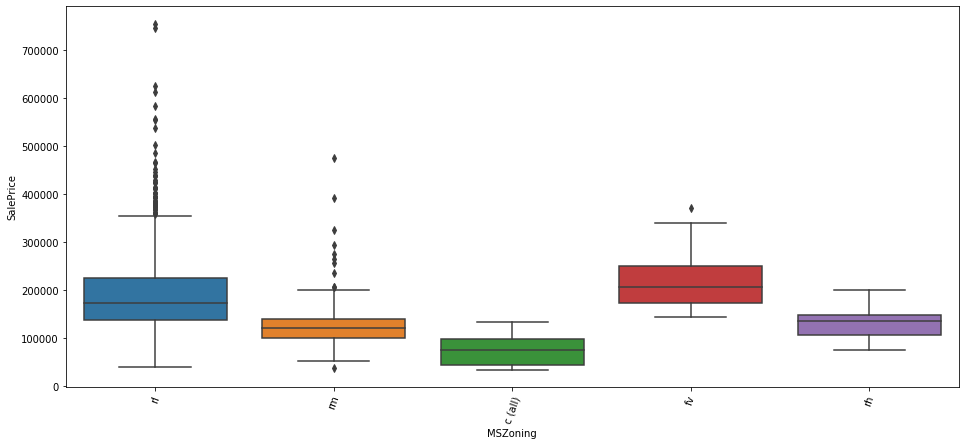

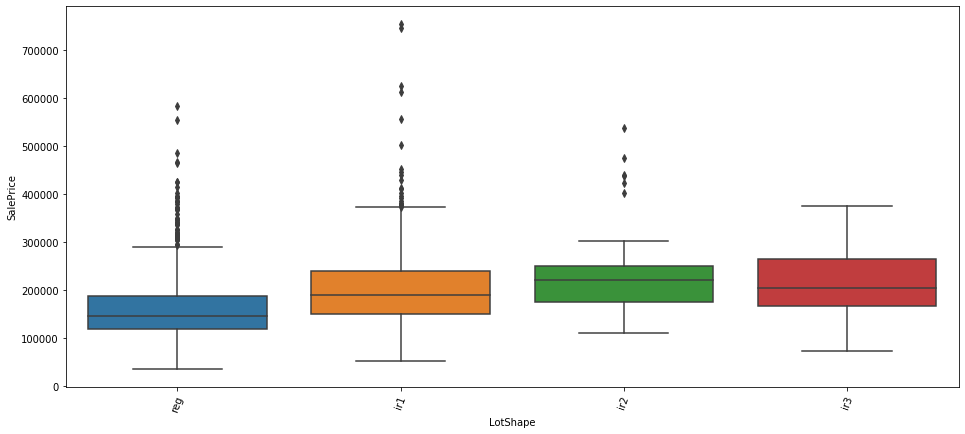

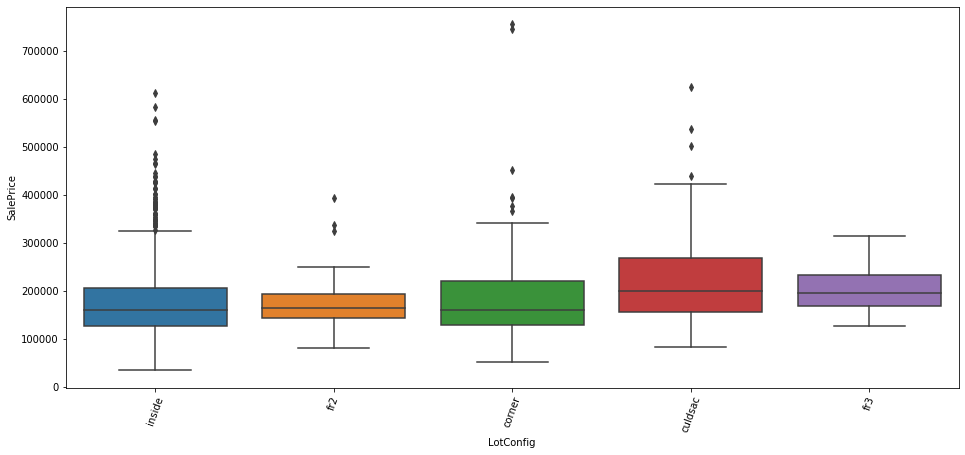

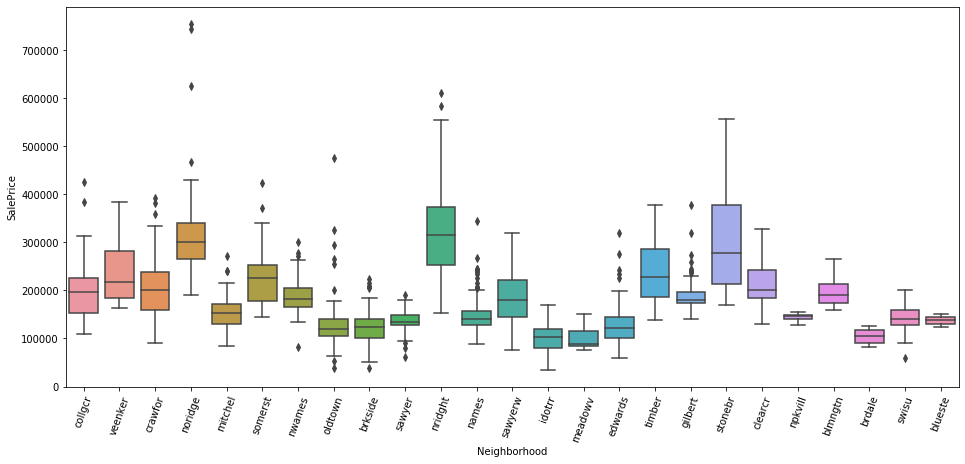

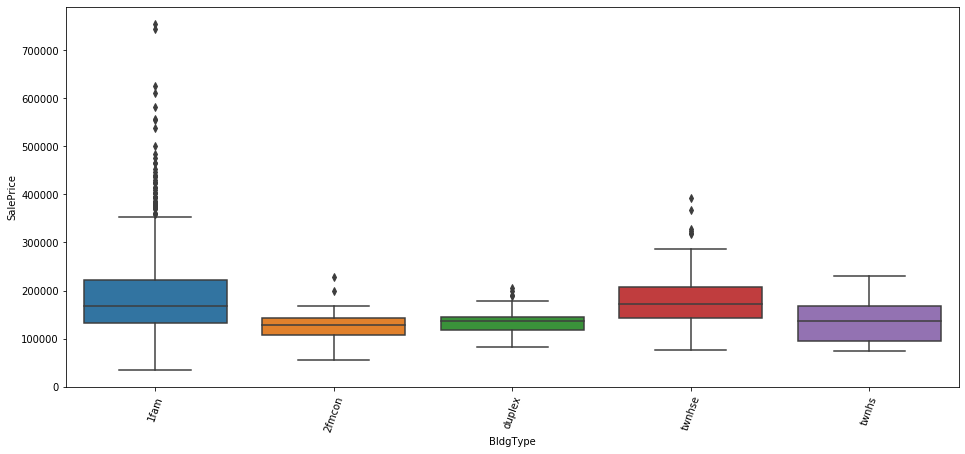

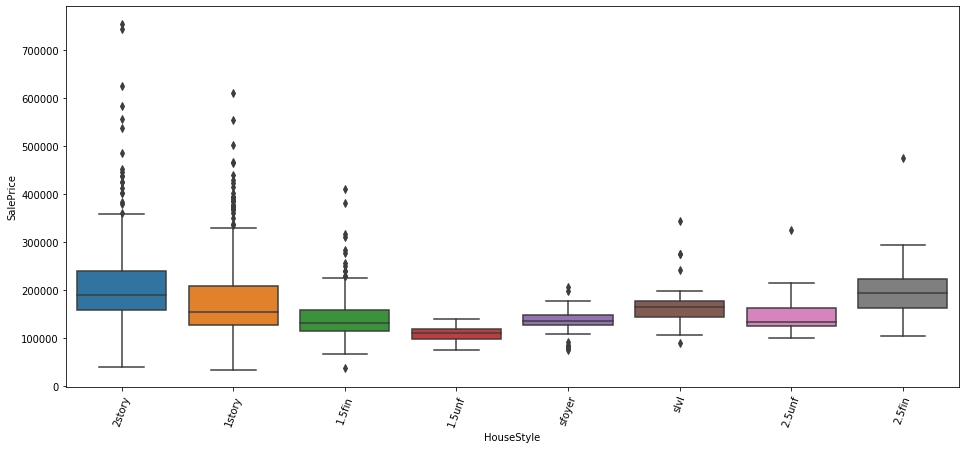

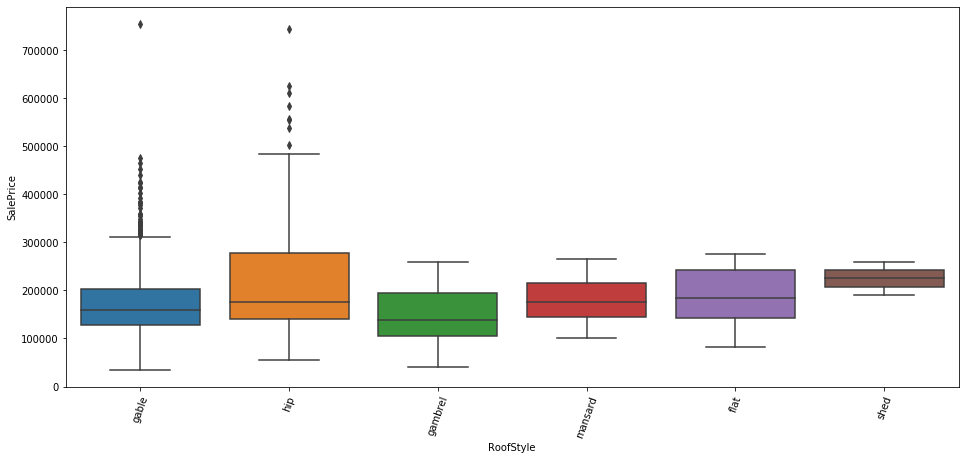

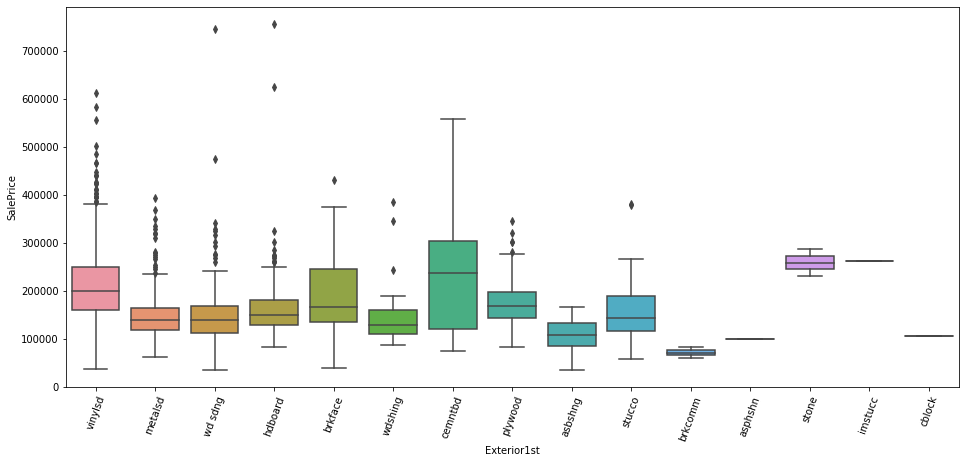

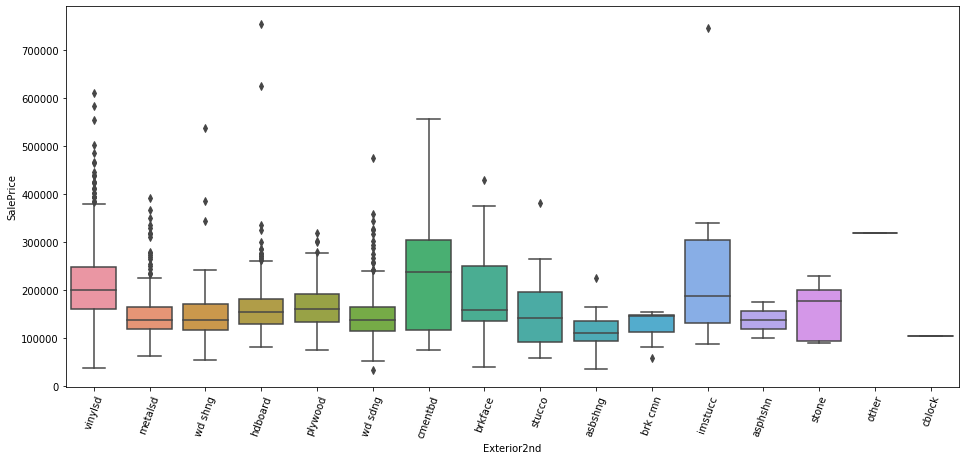

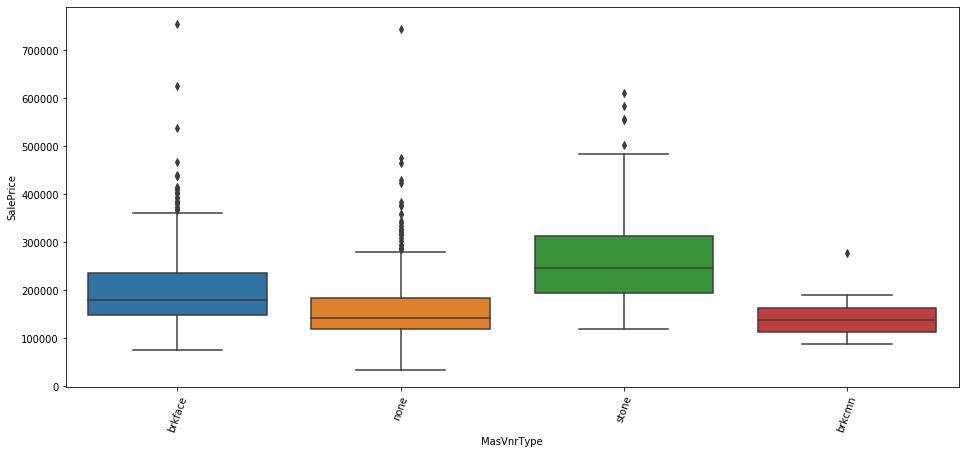

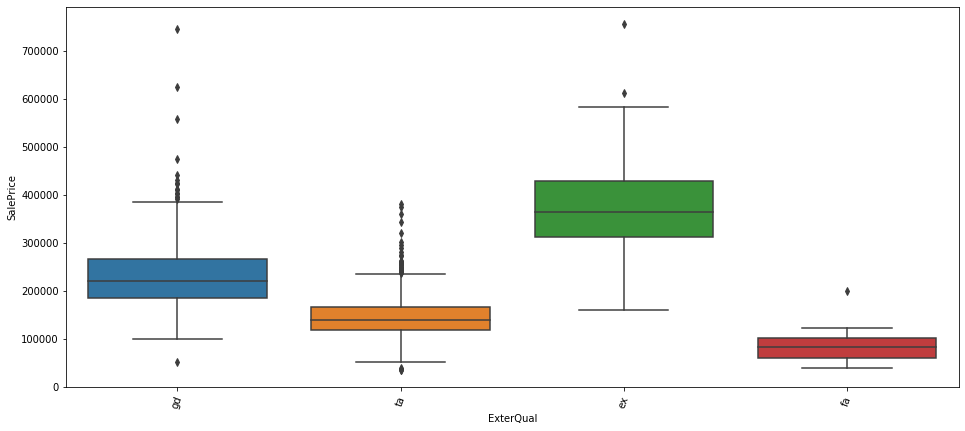

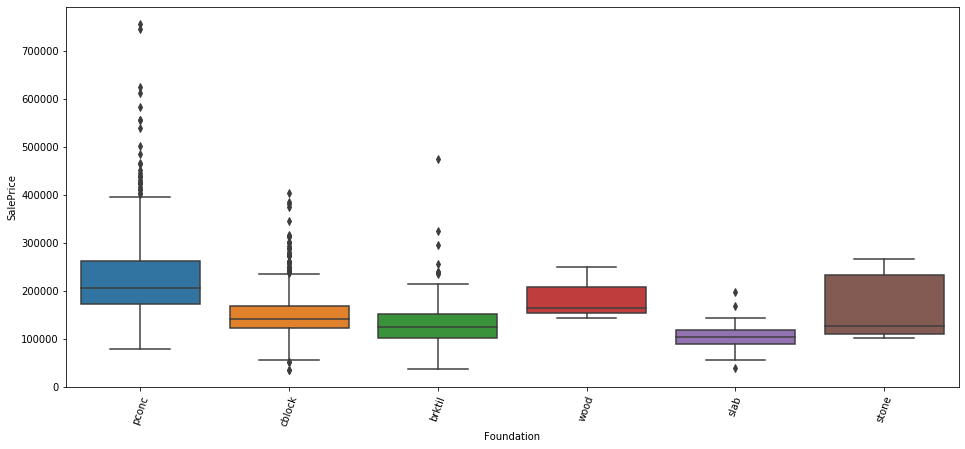

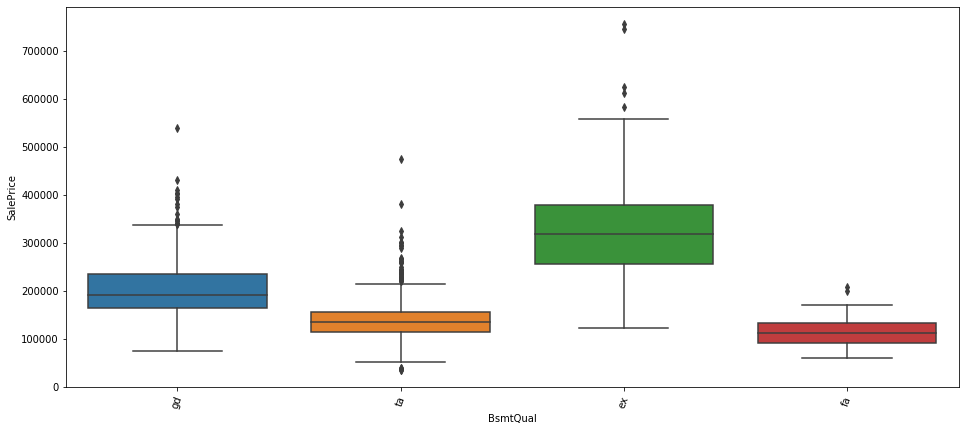

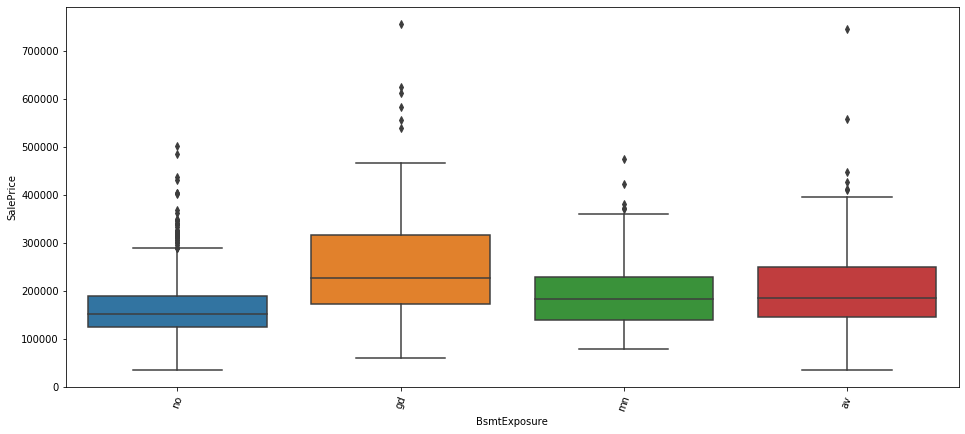

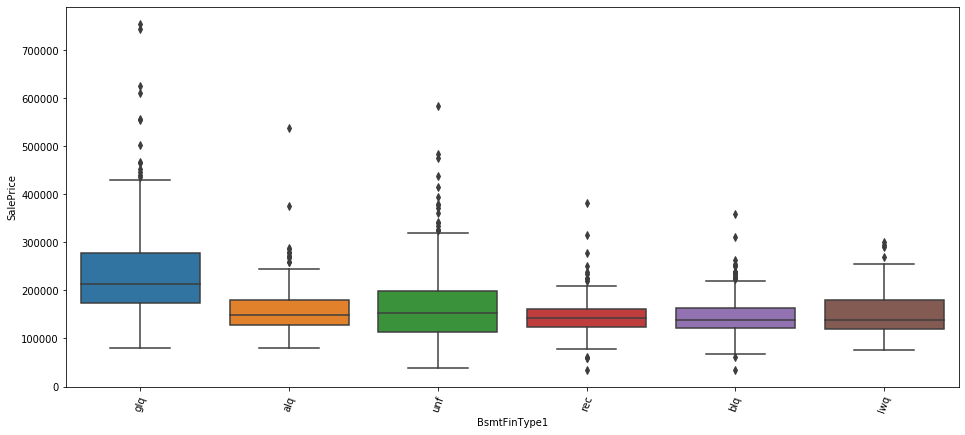

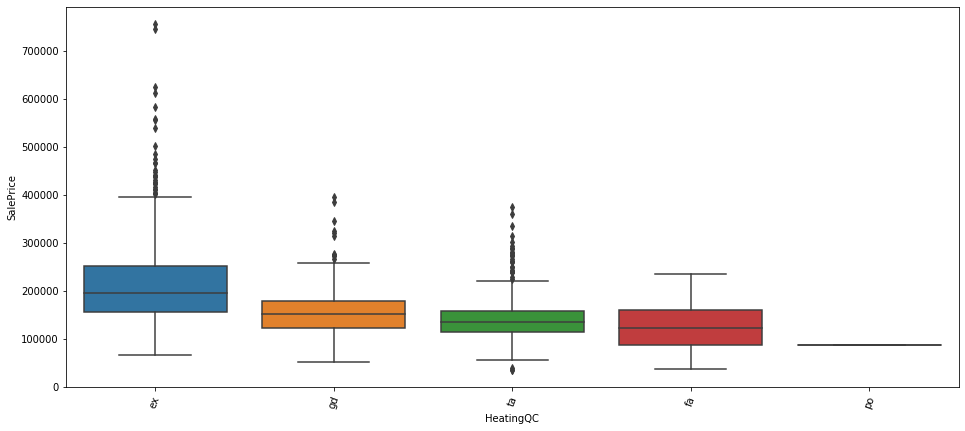

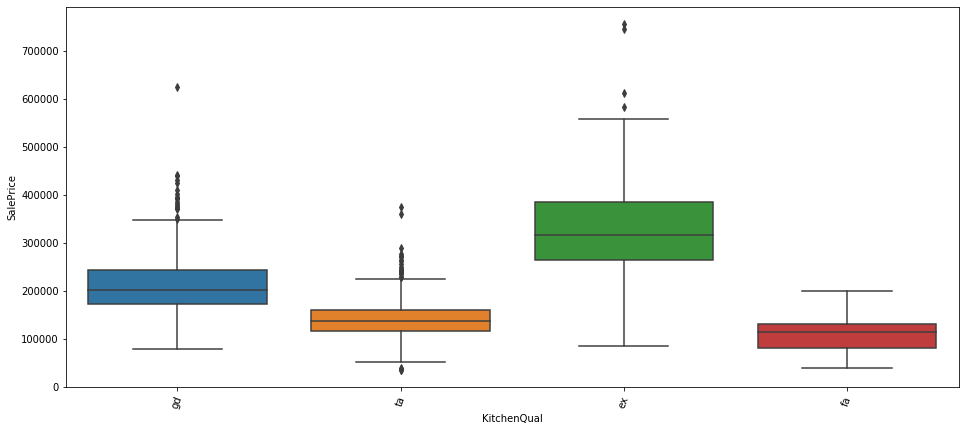

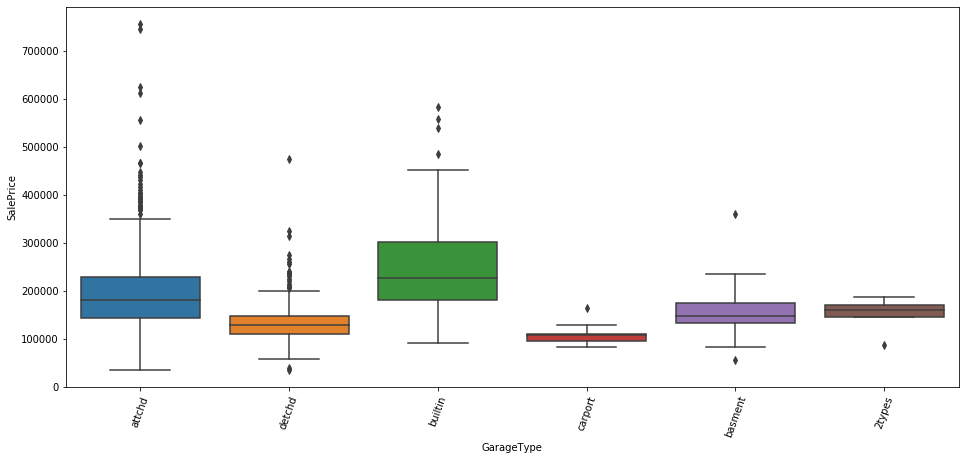

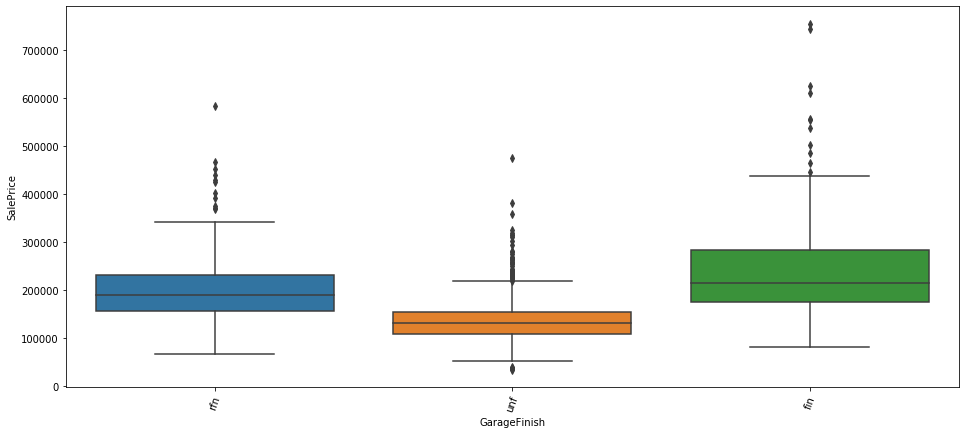

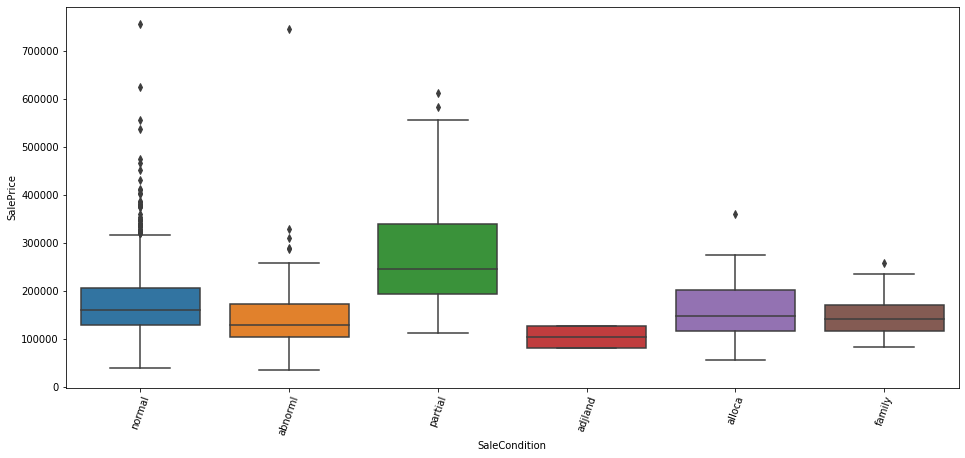

In [21]:
# Creating separate dataframe for Categorical values 

homeraw_categorical = homeraw.select_dtypes(include=['object'])
homeraw_categorical['SalePrice'] = homeraw['SalePrice']

#Plotting all the Categorical Values against SalePrice

for column in homeraw_categorical:
    if column == "SalePrice":
        break;
    else:
        plt.figure(figsize=(16, 7))
        sns.boxplot(x=column, y="SalePrice", data=homeraw_categorical)
        plt.xticks(rotation=70)
        
    

From Abve Box plots we can see we can compare the Categorical values and also see if some of them correlate higher with price.

In [22]:
# split into X and y
X = homeraw.drop(['SalePrice'], axis=1)

y = homeraw['SalePrice']


In [23]:
# Creating dummy variables for Categoricalvalues
homeraw_categorical1 = homeraw_categorical.drop(['SalePrice'], axis=1)
homeraw_dummies = pd.get_dummies(homeraw_categorical1, drop_first=True)
homeraw_dummies.head()

MSZoning_fv  MSZoning_rh  MSZoning_rl  MSZoning_rm  LotShape_ir2  \
0            0            0            1            0             0   
1            0            0            1            0             0   
2            0            0            1            0             0   
3            0            0            1            0             0   
4            0            0            1            0             0   

   LotShape_ir3  LotShape_reg  LotConfig_culdsac  LotConfig_fr2  \
0             0             1                  0              0   
1             0             1                  0              1   
2             0             0                  0              0   
3             0             0                  0              0   
4             0             0                  0              1   

   LotConfig_fr3  LotConfig_inside  Neighborhood_blueste  Neighborhood_brdale  \
0              0                 1                     0                    0   
1              0                 0                     0                    0   
2              0                 1                     0                    0   
3              0                 0                     0                    0   
4              0                 0                     0                    0   

   Neighborhood_brkside  Neighborhood_clearcr  Neighborhood_collgcr  \
0                     0                     0                     1   
1                     0                     0                     0   
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     0   

   Neighborhood_crawfor  Neighborhood_edwards  Neighborhood_gilbert  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     1                     0                     0   
4                     0                     0                     0   

   Neighborhood_idotrr  Neighborhood_meadowv  Neighborhood_mitchel  \
0                    0                     0                     0   
1                    0                     0                     0   
2                    0                     0                     0   
3                    0                     0                     0   
4                    0                     0                     0   

   Neighborhood_names  Neighborhood_noridge  Neighborhood_npkvill  \
0                   0                     0                     0   
1                   0                     0                     0   
2                   0                     0                     0   
3                   0                     0                     0   
4                   0                     1                     0   

   Neighborhood_nridght  Neighborhood_nwames  Neighborhood_oldtown  \
0                     0                    0                     0   
1                     0                    0                     0   
2                     0                    0                     0   
3                     0                    0                     0   
4                     0                    0                     0   

   Neighborhood_sawyer  Neighborhood_sawyerw  Neighborhood_somerst  \
0                    0                     0                     0   
1                    0                     0                     0   
2                    0                     0                     0   
3                    0                     0                     0   
4                    0                     0                     0   

   Neighborhood_stonebr  Neighborhood_swisu  Neighborhood_timber  \
0                     0                   0                    0   
1                 

In [24]:
# drop categorical variables 
X = X.drop(list(homeraw_categorical1.columns), axis=1)

# concat dummy variables with X
X = pd.concat([X, homeraw_dummies], axis=1)

In [25]:
# scaling the features
from sklearn.preprocessing import scale

# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       ...
       'GarageType_builtin', 'GarageType_carport', 'GarageType_detchd',
       'GarageFinish_rfn', 'GarageFinish_unf', 'SaleCondition_adjland',
       'SaleCondition_alloca', 'SaleCondition_family', 'SaleCondition_normal',
       'SaleCondition_partial'],
      dtype='object', length=155)

In [26]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

# Ridge Regression

In [27]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation
folds = 5
model_cv1 = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv1.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [28]:
cv_results1 = pd.DataFrame(model_cv1.cv_results_)
cv_results1 = cv_results1[cv_results1['param_alpha']<=1000]
cv_results1.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.007198      0.003540         0.001398        0.000489      0.0001   
1       0.006197      0.001469         0.001998        0.000894       0.001   
2       0.005199      0.000747         0.001598        0.000489        0.01   
3       0.005598      0.000801         0.001798        0.000748        0.05   
4       0.007797      0.001719         0.001597        0.000489         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}      -20542.969624      -21253.192395      -22040.937402   
1   {'alpha': 0.001}      -20542.860072      -21253.062389      -22040.848076   
2    {'alpha': 0.01}      -20541.765263      -21251.770599      -22039.958716   
3    {'alpha': 0.05}      -20536.914576      -21246.203787      -22036.088595   
4     {'alpha': 0.1}      -20530.883794      -21239.615167      -22031.427287   

   split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0      -19277.670676      -20799.633302    -20782.880680      908.558743   
1      -19277.417683      -20799.531755    -20782.743995      908.609785   
2      -19274.903625      -20798.515859    -20781.382812      909.116893   
3      -19264.408019      -20793.992673    -20775.521530      911.187096   
4      -19252.045606      -20788.324676    -20768.459306      913.610774   

   rank_test_score  split0_train_score  split1_train_score  \
0               28       -17120.980320       -13764.043044   
1               27       -17120.939287       -13764.051820   
2               26       -17120.529574       -13764.138026   
3               25       -17118.992101       -13764.493005   
4               24       -17117.121681       -13764.900204   

   split2_train_score  split3_train_score  split4_train_score  \
0       -16042.014159       -17122.126574       -16746.970491   
1       -16041.981889       -17122.091613       -16746.952484   
2       -16041.660613       -17121.742484       -16746.772317   
3       -16040.234312       -17120.200827       -16745.969583   
4       -16038.434176       -17118.295027       -16744.961931   

   mean_train_score  std_train_score  
0     -16159.226917      1260.811840  
1     -16159.203419      1260.795827  
2     -16158.968603      1260.636420  
3     -16157.977966      1259.983252  
4     -16156.742604      1259.191801

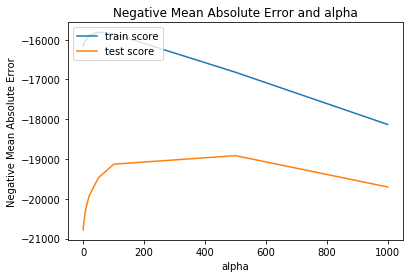

In [29]:
# plotting mean test and train scoes with alpha 
cv_results1['param_alpha'] = cv_results1['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results1['param_alpha'], cv_results1['mean_train_score'])
plt.plot(cv_results1['param_alpha'], cv_results1['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [30]:
alpha1 = 500
ridge = Ridge(alpha=alpha1)

ridge.fit(X_train, y_train)
ridge.coef_

array([-2698.6462386 ,   390.33202998,  2863.16680213,  9768.33151275,
        2841.56867554,  2375.65770916,   295.01896795,  1192.42829786,
        3779.34745705,  5117.8005587 ,  5048.64986864,  -700.49660006,
        7894.29634266,  2614.25073725,   385.65179696,  4247.1990803 ,
        2500.49204948,    67.03390935, -2182.34796609,  4150.38725632,
        3961.30795057,  4596.90199027,  3406.48377908,  2182.25702551,
         431.58166039,  -191.91695987,   902.25672392,  1204.13564104,
         -71.98109231,  -224.52714424,  -143.69793938,  -796.62142671,
       -3151.46845072, -1771.37047034,  1075.52618888,   281.86734853,
        1142.91143776, -1082.32712735,   397.71124985, -2268.20159068,
        -409.24371669,  1952.22317227, -1478.03593637,  -693.94879123,
        -151.29049398,    87.27311144,   -11.90813458,   -17.70544171,
         286.33560307, -1095.4913894 ,  3140.57667573, -3319.14803456,
       -1311.75415523,  -888.93967338,  -535.48404459, -1551.34095528,
      

In [31]:
import sklearn.metrics as metrics
# predict
y_train_pred = ridge.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = ridge.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.8565299087143201
0.853039805637795


# Ridge Model Parameters

In [32]:
# ridge model parameters
model_parameters = list(ridge.coef_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
list(zip(cols, model_parameters))

[('MSSubClass', -2698.646),
 ('LotFrontage', 390.332),
 ('LotArea', 2863.167),
 ('OverallQual', 9768.332),
 ('OverallCond', 2841.569),
 ('BsmtFinSF1', 2375.658),
 ('BsmtFinSF2', 295.019),
 ('BsmtUnfSF', 1192.428),
 ('TotalBsmtSF', 3779.347),
 ('1stFlrSF', 5117.801),
 ('2ndFlrSF', 5048.65),
 ('LowQualFinSF', -700.497),
 ('GrLivArea', 7894.296),
 ('BsmtFullBath', 2614.251),
 ('BsmtHalfBath', 385.652),
 ('FullBath', 4247.199),
 ('HalfBath', 2500.492),
 ('BedroomAbvGr', 67.034),
 ('KitchenAbvGr', -2182.348),
 ('TotRmsAbvGrd', 4150.387),
 ('Fireplaces', 3961.308),
 ('GarageCars', 4596.902),
 ('GarageArea', 3406.484),
 ('WoodDeckSF', 2182.257),
 ('OpenPorchSF', 431.582),
 ('EnclosedPorch', -191.917),
 ('3SsnPorch', 902.257),
 ('ScreenPorch', 1204.136),
 ('PoolArea', -71.981),
 ('MiscVal', -224.527),
 ('MoSold', -143.698),
 ('YrSold', -796.621),
 ('age', -3151.468),
 ('garageage', -1771.37),
 ('MSZoning_fv', 1075.526),
 ('MSZoning_rh', 281.867),
 ('MSZoning_rl', 1142.911),
 ('MSZoning_rm', -1

# Lasso Regression

In [33]:
lasso = Lasso()

# cross validation
model_cv2 = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv2.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:   20.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [34]:
cv_results2 = pd.DataFrame(model_cv2.cv_results_)
cv_results2.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.162706      0.011849         0.002400    4.904864e-04      0.0001   
1       0.162706      0.010919         0.001799    7.473987e-04       0.001   
2       0.163505      0.006854         0.001999    6.311285e-04        0.01   
3       0.160106      0.012882         0.002000    8.476443e-07        0.05   
4       0.158509      0.011987         0.001599    4.887141e-04         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}      -20542.722399      -21246.792228      -22038.355934   
1   {'alpha': 0.001}      -20542.705029      -21246.772341      -22038.343686   
2    {'alpha': 0.01}      -20542.531328      -21246.573488      -22038.221269   
3    {'alpha': 0.05}      -20541.755878      -21245.689917      -22037.678563   
4     {'alpha': 0.1}      -20540.831523      -21244.585985      -22037.003507   

   split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0      -19262.720149      -20828.515277    -20783.821197      912.367708   
1      -19262.693040      -20828.158382    -20783.734495      912.368792   
2      -19262.421903      -20824.589435    -20782.867484      912.380769   
3      -19261.147329      -20821.273252    -20781.508988      912.577478   
4      -19259.589244      -20820.479442    -20780.497940      912.840153   

   rank_test_score  split0_train_score  split1_train_score  \
0               28       -17120.914891       -13765.808657   
1               27       -17120.910234       -13765.808427   
2               26       -17120.863705       -13765.806122   
3               25       -17120.662346       -13765.795816   
4               24       -17120.429018       -13765.785934   

   split2_train_score  split3_train_score  split4_train_score  \
0       -16042.250433       -17121.853401       -16746.974779   
1       -16042.248068       -17121.849731       -16746.971873   
2       -16042.225105       -17121.814809       -16746.943952   
3       -16042.123893       -17121.665937       -16746.814870   
4       -16041.998646       -17121.482704       -16746.655014   

   mean_train_score  std_train_score  
0     -16159.560432      1260.085312  
1     -16159.557667      1260.083901  
2     -16159.530739      1260.070168  
3     -16159.412572      1260.010471  
4     -16159.270263      1259.938065

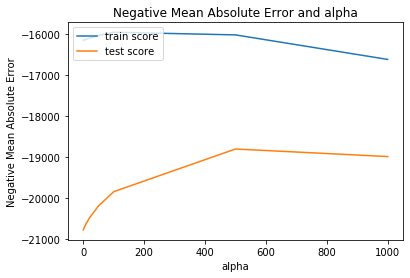

In [35]:
# plotting mean test and train scoes with alpha 
cv_results2['param_alpha'] = cv_results2['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results2['param_alpha'], cv_results2['mean_train_score'])
plt.plot(cv_results2['param_alpha'], cv_results2['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [36]:
alpha2 = 500

lasso = Lasso(alpha=alpha2)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=500, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [37]:
lasso.coef_

array([-6.86224530e+03, -1.19946795e+03,  3.75699200e+03,  1.54350317e+04,
        3.69200590e+03,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        6.25497158e+02,  0.00000000e+00,  1.90516986e+03, -1.68700777e+03,
        2.28354131e+04,  3.88554620e+03,  3.42285224e+02,  4.22983798e+03,
        1.30035934e+03, -0.00000000e+00, -2.07394112e+03,  2.98677048e+01,
        2.38580800e+03,  6.64472718e+03,  0.00000000e+00,  1.48229943e+03,
       -2.93819704e+02, -0.00000000e+00,  8.15384779e+02,  7.14030626e+02,
       -3.73425781e+01, -0.00000000e+00, -0.00000000e+00, -5.54662128e+02,
       -3.08513661e+03, -1.21480425e+03,  0.00000000e+00,  0.00000000e+00,
        1.44334761e+03, -0.00000000e+00,  0.00000000e+00, -2.32915710e+03,
        0.00000000e+00,  1.72428095e+03, -1.81617233e+03, -5.31062681e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        4.36246496e+02,  2.58887088e+02,  4.31490569e+03, -3.55882294e+03,
        0.00000000e+00, -

In [38]:
import sklearn.metrics as metrics
# predict
y_train_pred = lasso.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lasso.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.878925629186904
0.8616245226887983


# Lasso Model Parameters

In [39]:
# lasso model parameters
model_parameters = list(lasso.coef_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
list(zip(cols, model_parameters))

[('MSSubClass', -6862.245),
 ('LotFrontage', -1199.468),
 ('LotArea', 3756.992),
 ('OverallQual', 15435.032),
 ('OverallCond', 3692.006),
 ('BsmtFinSF1', 0.0),
 ('BsmtFinSF2', -0.0),
 ('BsmtUnfSF', 0.0),
 ('TotalBsmtSF', 625.497),
 ('1stFlrSF', 0.0),
 ('2ndFlrSF', 1905.17),
 ('LowQualFinSF', -1687.008),
 ('GrLivArea', 22835.413),
 ('BsmtFullBath', 3885.546),
 ('BsmtHalfBath', 342.285),
 ('FullBath', 4229.838),
 ('HalfBath', 1300.359),
 ('BedroomAbvGr', -0.0),
 ('KitchenAbvGr', -2073.941),
 ('TotRmsAbvGrd', 29.868),
 ('Fireplaces', 2385.808),
 ('GarageCars', 6644.727),
 ('GarageArea', 0.0),
 ('WoodDeckSF', 1482.299),
 ('OpenPorchSF', -293.82),
 ('EnclosedPorch', -0.0),
 ('3SsnPorch', 815.385),
 ('ScreenPorch', 714.031),
 ('PoolArea', -37.343),
 ('MiscVal', -0.0),
 ('MoSold', -0.0),
 ('YrSold', -554.662),
 ('age', -3085.137),
 ('garageage', -1214.804),
 ('MSZoning_fv', 0.0),
 ('MSZoning_rh', 0.0),
 ('MSZoning_rl', 1443.348),
 ('MSZoning_rm', -0.0),
 ('LotShape_ir2', 0.0),
 ('LotShape_ir3

# Linear Regression using Stats Model to Compare

In [40]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [42]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('MSSubClass', False, 104),
 ('LotFrontage', False, 21),
 ('LotArea', False, 24),
 ('OverallQual', True, 1),
 ('OverallCond', False, 17),
 ('BsmtFinSF1', True, 1),
 ('BsmtFinSF2', True, 1),
 ('BsmtUnfSF', False, 5),
 ('TotalBsmtSF', False, 4),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('LowQualFinSF', False, 3),
 ('GrLivArea', False, 2),
 ('BsmtFullBath', False, 12),
 ('BsmtHalfBath', False, 56),
 ('FullBath', False, 14),
 ('HalfBath', False, 74),
 ('BedroomAbvGr', False, 51),
 ('KitchenAbvGr', False, 13),
 ('TotRmsAbvGrd', False, 52),
 ('Fireplaces', False, 48),
 ('GarageCars', False, 20),
 ('GarageArea', False, 25),
 ('WoodDeckSF', False, 72),
 ('OpenPorchSF', False, 77),
 ('EnclosedPorch', False, 112),
 ('3SsnPorch', False, 73),
 ('ScreenPorch', False, 83),
 ('PoolArea', False, 122),
 ('MiscVal', False, 128),
 ('MoSold', False, 113),
 ('YrSold', False, 87),
 ('age', False, 33),
 ('garageage', True, 1),
 ('MSZoning_fv', False, 29),
 ('MSZoning_rh', False, 31),
 ('MSZoning_rl'

In [43]:
#Features coarsely selected with RFE
col1 = X_train.columns[rfe.support_]
col1

Index(['OverallQual', 'BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF',
       'garageage', 'Neighborhood_crawfor', 'Neighborhood_noridge',
       'Neighborhood_nridght', 'BldgType_twnhs', 'BldgType_twnhse',
       'HouseStyle_1story', 'BsmtQual_fa', 'BsmtQual_gd', 'BsmtQual_ta',
       'BsmtExposure_gd', 'BsmtExposure_no', 'KitchenQual_fa',
       'KitchenQual_gd', 'KitchenQual_ta'],
      dtype='object')

In [44]:
num_var = X_train.columns[~rfe.support_]

In [45]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col1]

In [46]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

In [47]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [48]:
#summary of linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     257.3
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:43:04   Log-Likelihood:                -12037.
No. Observations:                1021   AIC:                         2.412e+04
Df Residuals:                    1000   BIC:                         2.422e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   1.8e+05 

In [49]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
20        KitchenQual_ta  8.04
15           BsmtQual_ta  7.77
19        KitchenQual_gd  6.34
14           BsmtQual_gd  5.29
5               2ndFlrSF  3.31
12     HouseStyle_1story  3.17
1            OverallQual  3.01
6              garageage  2.33
4               1stFlrSF  2.19
18        KitchenQual_fa  1.90
13           BsmtQual_fa  1.77
17       BsmtExposure_no  1.49
2             BsmtFinSF1  1.46
9   Neighborhood_nridght  1.46
16       BsmtExposure_gd  1.43
8   Neighborhood_noridge  1.23
11       BldgType_twnhse  1.17
10        BldgType_twnhs  1.12
3             BsmtFinSF2  1.09
7   Neighborhood_crawfor  1.07
0                  const  1.01

In [50]:
#Dropping KitchenQual_ta as its having high VIF
X_train_new = X_train_rfe.drop(["KitchenQual_ta"], axis = 1)

In [51]:
lm = sm.OLS(y_train,X_train_new).fit()   # Running the linear model

In [52]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     253.3
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:43:04   Log-Likelihood:                -12065.
No. Observations:                1021   AIC:                         2.417e+04
Df Residuals:                    1001   BIC:                         2.427e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.798e+05 

In [53]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
15           BsmtQual_ta  7.50
14           BsmtQual_gd  5.00
5               2ndFlrSF  3.31
12     HouseStyle_1story  3.17
1            OverallQual  2.80
6              garageage  2.33
4               1stFlrSF  2.15
13           BsmtQual_fa  1.75
19        KitchenQual_gd  1.49
17       BsmtExposure_no  1.49
2             BsmtFinSF1  1.45
16       BsmtExposure_gd  1.43
9   Neighborhood_nridght  1.39
8   Neighborhood_noridge  1.22
11       BldgType_twnhse  1.17
10        BldgType_twnhs  1.12
3             BsmtFinSF2  1.09
18        KitchenQual_fa  1.08
7   Neighborhood_crawfor  1.07
0                  const  1.01

In [54]:
#Dropping KitchenQual_gd as its insignificant
X_train_new = X_train_new.drop(["KitchenQual_gd"], axis = 1)

In [55]:
lm = sm.OLS(y_train,X_train_new).fit()   # Running the linear model

In [56]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     267.4
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:43:04   Log-Likelihood:                -12066.
No. Observations:                1021   AIC:                         2.417e+04
Df Residuals:                    1002   BIC:                         2.426e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.799e+05 

In [57]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
15           BsmtQual_ta  7.45
14           BsmtQual_gd  4.81
5               2ndFlrSF  3.30
12     HouseStyle_1story  3.15
1            OverallQual  2.71
6              garageage  2.24
4               1stFlrSF  2.15
13           BsmtQual_fa  1.74
17       BsmtExposure_no  1.48
2             BsmtFinSF1  1.44
16       BsmtExposure_gd  1.43
9   Neighborhood_nridght  1.38
8   Neighborhood_noridge  1.22
11       BldgType_twnhse  1.17
10        BldgType_twnhs  1.12
3             BsmtFinSF2  1.09
18        KitchenQual_fa  1.07
7   Neighborhood_crawfor  1.07
0                  const  1.01

In [58]:
#Dropping KitchenQual_fa as its insignificant
X_train_new = X_train_new.drop(["KitchenQual_fa"], axis = 1)

In [59]:
lm = sm.OLS(y_train,X_train_new).fit()   # Running the linear model

In [60]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     282.9
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:43:04   Log-Likelihood:                -12066.
No. Observations:                1021   AIC:                         2.417e+04
Df Residuals:                    1003   BIC:                         2.426e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.799e+05 

In [61]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
15           BsmtQual_ta  7.43
14           BsmtQual_gd  4.81
5               2ndFlrSF  3.29
12     HouseStyle_1story  3.14
1            OverallQual  2.69
6              garageage  2.17
4               1stFlrSF  2.15
13           BsmtQual_fa  1.74
17       BsmtExposure_no  1.48
2             BsmtFinSF1  1.44
16       BsmtExposure_gd  1.42
9   Neighborhood_nridght  1.38
8   Neighborhood_noridge  1.22
11       BldgType_twnhse  1.17
10        BldgType_twnhs  1.12
3             BsmtFinSF2  1.08
7   Neighborhood_crawfor  1.07
0                  const  1.01

In [62]:
#Dropping BsmtQual_ta as its VIF is high
X_train_new = X_train_new.drop(["BsmtQual_ta"], axis = 1)

In [63]:
lm = sm.OLS(y_train,X_train_new).fit()   # Running the linear model

In [64]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     278.5
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:43:04   Log-Likelihood:                -12099.
No. Observations:                1021   AIC:                         2.423e+04
Df Residuals:                    1004   BIC:                         2.432e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.798e+05 

In [65]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
5               2ndFlrSF  3.26
12     HouseStyle_1story  3.13
1            OverallQual  2.47
4               1stFlrSF  2.15
6              garageage  1.97
14           BsmtQual_gd  1.52
16       BsmtExposure_no  1.45
2             BsmtFinSF1  1.42
15       BsmtExposure_gd  1.41
9   Neighborhood_nridght  1.30
8   Neighborhood_noridge  1.22
11       BldgType_twnhse  1.16
10        BldgType_twnhs  1.12
3             BsmtFinSF2  1.08
7   Neighborhood_crawfor  1.07
13           BsmtQual_fa  1.05
0                  const  1.01

In [66]:
#Dropping BsmtQual_fa as its insignificant
X_train_new = X_train_new.drop(["BsmtQual_fa"], axis = 1)

In [67]:
lm = sm.OLS(y_train,X_train_new).fit()   # Running the linear model

In [68]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     297.3
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:43:04   Log-Likelihood:                -12099.
No. Observations:                1021   AIC:                         2.423e+04
Df Residuals:                    1005   BIC:                         2.431e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.798e+05 

In [69]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
5               2ndFlrSF  3.26
12     HouseStyle_1story  3.13
1            OverallQual  2.46
4               1stFlrSF  2.15
6              garageage  1.95
13           BsmtQual_gd  1.51
15       BsmtExposure_no  1.45
2             BsmtFinSF1  1.41
14       BsmtExposure_gd  1.41
9   Neighborhood_nridght  1.30
8   Neighborhood_noridge  1.22
11       BldgType_twnhse  1.16
10        BldgType_twnhs  1.11
3             BsmtFinSF2  1.07
7   Neighborhood_crawfor  1.07
0                  const  1.01

In [70]:
#Dropping BsmtFinSF2 as its insignificant
X_train_new = X_train_new.drop(["BsmtFinSF2"], axis = 1)

In [71]:
lm = sm.OLS(y_train,X_train_new).fit()   # Running the linear model

In [72]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     317.7
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:43:04   Log-Likelihood:                -12101.
No. Observations:                1021   AIC:                         2.423e+04
Df Residuals:                    1006   BIC:                         2.431e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.798e+05 

In [73]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
4               2ndFlrSF  3.26
11     HouseStyle_1story  3.13
1            OverallQual  2.46
3               1stFlrSF  2.11
5              garageage  1.95
12           BsmtQual_gd  1.51
14       BsmtExposure_no  1.44
13       BsmtExposure_gd  1.40
2             BsmtFinSF1  1.38
8   Neighborhood_nridght  1.30
7   Neighborhood_noridge  1.22
10       BldgType_twnhse  1.15
9         BldgType_twnhs  1.11
6   Neighborhood_crawfor  1.07
0                  const  1.01

In [74]:
y_train_price = lm.predict(X_train_new)

In [75]:
from sklearn.metrics import r2_score

r2=r2_score(y_train, y_train_price)
print('Train Model r2_score:',r2)

Train Model r2_score: 0.8155415936494008


Text(0.5, 0, 'Errors')

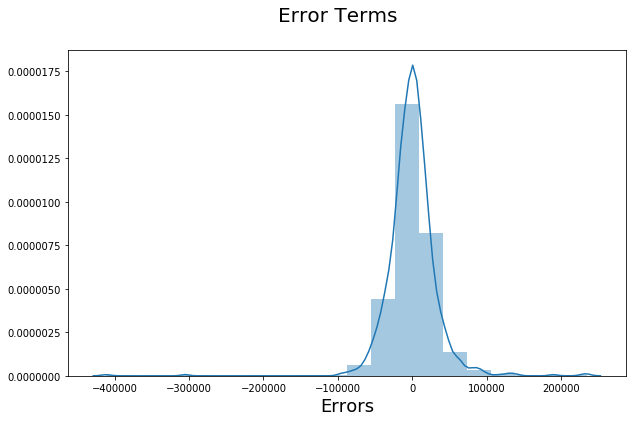

In [76]:
# Plot the histogram of the error terms
fig = plt.figure(figsize=(10, 6))
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

Error Term is showing a Normal Curve with Mean and Median at Zero

In [77]:
X_test["const"] = 1.0

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]



In [78]:
X_test_new.head()

const  OverallQual  BsmtFinSF1  1stFlrSF  2ndFlrSF  garageage  \
1436    1.0    -1.518467    0.378031 -0.772733 -0.795163   0.095352   
57      1.0     0.651479   -0.973018 -0.783083  1.175601  -1.045431   
780     1.0     0.651479   -0.973018  0.233852 -0.795163  -0.703196   
382     1.0     0.651479   -0.973018 -0.578661  1.171018  -1.121483   
1170    1.0    -0.071836    0.171865 -0.115477 -0.795163  -0.018727   

      Neighborhood_crawfor  Neighborhood_noridge  Neighborhood_nridght  \
1436             -0.190252             -0.169981             -0.235958   
57               -0.190252             -0.169981             -0.235958   
780              -0.190252             -0.169981             -0.235958   
382              -0.190252             -0.169981             -0.235958   
1170             -0.190252             -0.169981             -0.235958   

      BldgType_twnhs  BldgType_twnhse  HouseStyle_1story  BsmtQual_gd  \
1436         -0.1742        -0.291025           1.005495    -0.856719   
57           -0.1742        -0.291025          -0.994535     1.167244   
780          -0.1742        -0.291025           1.005495     1.167244   
382          -0.1742        -0.291025          -0.994535     1.167244   
1170         -0.1742        -0.291025          -0.994535    -0.856719   

      BsmtExposure_gd  BsmtExposure_no  
1436        -0.317893         0.687938  
57          -0.317893         0.687938  
780         -0.317893         0.687938  
382         -0.317893        -1.453618  
1170        -0.317893        -1.453618

In [79]:
# Making predictions using stats model
y_pred = lm.predict(X_test_new)

Text(0, 0.5, 'y_pred')

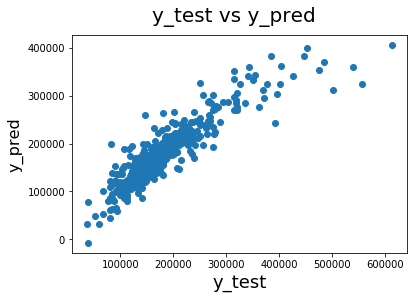

In [80]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

In [81]:
r2=r2_score(y_test, y_pred)
print('Test Model r2_score:',r2)

Test Model r2_score: 0.809331981223378


# Conclusions

As per Stats Model:
---------------------------

SalePrice = (179800 * const) + (29750 * OverallQual) + (26240 * 2ndFlrSF) + (18640 * 1stFlrSF) - (13270 * garageage) + (10290 * HouseStyle_1story) + (10240 * Neighborhood_nridght) + (9774.3645 * Neighborhood_noridge) - (6953.3818 * BsmtExposure_no) + (6774.462 * BsmtExposure_gd) + (5549.6541 * BsmtFinSF1) + (5547.3393 * Neighborhood_crawfor) - (5238.1716 * BldgType_twnhs) - (4347.8537 * BsmtQual_gd) - (4235.2602 * BldgType_twnhse)


Train R2 = 81.5 and Test R2 = 80.9

For Lasso:
----------

The Alpha value = 500

The Coefficients are dispalyed above in Lasso section with Training R2 = 87 and Test R2 = 86

Top 10 Predictors as per coeffecients for Lasso --> (22835.413 * GrLivArea) + (15435.032 * OverallQual) - (13738.848 * BsmtQual_gd) - (12791.545 * BsmtQual_ta) + (9911.126 * Neighborhood_noridge) - (9580.675 * KitchenQual_ta) - (9341.302 * KitchenQual_gd) + (8889.712 * Neighborhood_nridght) - (6862.245 * MSSubClass) + (6644.727 * GarageCars)


For Ridge:
---------------
The Alpha value = 500

The Coefficients are dispalyed above in Ridge section with Training R2 = 85 and Test R2 = 85

Top 10 Predictors as per coeffecients for Ridge --> (9768.332 * OverallQual) + (7894.296 * GrLivArea) + (7036.677 * Neighborhood_noridge) + (6398.631 * Neighborhood_nridght) + (5117.801 * 1stFlrSF) + (5048.65 * 2ndFlrSF) - (4861.166 * BsmtQual_gd) + (4747.616 * BsmtExposure_gd) + (4596.902 * GarageCars) + (4247.199 * FullBath)
